# Diving into BoardGameGeek
> 3 Key Insights from 19M reviews

- toc: false
- branch: master
- badges: true
- comments: true
- author: Jesse van Elteren
- image: images/
- categories: []

![](images/bgg.jpg)

If you like boardgames, there is a good chance you are thinking of buying another one. It's a bit of a guilty pleasure in which I also indulge sometimes. Many people turn to [BoardGameGeek (BGG)](https://boardgamegeek.com/), which is a great site with many active users reviewing games. I used the BGG API to download:
* 19M reviews (users giving games a rating)
* 21K games (game type, complexity, minimum age etc)

I wanted to see what affects the final rating of a game. TLDR:
* Newer games receive higher ratings
* More complex games receive higher ratings
* Less active users give higher ratings
* Fake reviews do play a role in the scores

### The users and ratings

In [740]:
# hide
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
import warnings
from pandas.errors import DtypeWarning
from sklearn.model_selection import train_test_split
import lightgbm as lgb

from utils.database import DB
from aocutils.datascience import nan_inspect, save, load

warnings.simplefilter(action='ignore', category=DtypeWarning)
pd.options.display.max_rows = 200

In [741]:
# hide
# # metric for corretlation of categorial features with target. Used for sorting features in displaying


def types(data, y_col):
    # split columns into sorted numerical and categorical based on correlation with y_col
    corr = data.corr()[y_col]
    corr = corr.sort_values(ascending=False)
    num_x = list(corr.index)[1:]

    cat_x = [col for col in data.columns if data[col].dtype == 'object']
    cat_x.sort(key = lambda x: -correlation_ratio(data[x],data[y_col]))
    
    return num_x, cat_x


def split(data, y_col):
    # splits dataset into x and y dataset
    data_x = data.drop([y_col], axis=1)
    data_y = data.loc[:,y_col]
    return data_x, data_y

    
    


def correlation_ratio(categories, measurements):
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat)+1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    for i in range(0,cat_num):
        cat_measures = measurements[np.argwhere(fcat == i).flatten()]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.average(cat_measures)
    y_total_avg = np.sum(np.multiply(y_avg_array,n_array))/np.sum(n_array)
    numerator = np.sum(np.multiply(n_array,np.power(np.subtract(y_avg_array,y_total_avg),2)))
    denominator = np.sum(np.power(np.subtract(measurements,y_total_avg),2))
    if numerator == 0:
        eta = 0.0
    else:
        eta = np.sqrt(numerator/denominator)
    return eta

def regr(x, y, s=0.01):
    regr = linear_model.LinearRegression()
    x = x.values.reshape(-1, 1)
    regr.fit(x, y)
    print(f'r2: {regr.score(x, y):.2f}')
    # plot it as in the example at http://scikit-learn.org/
    plt.scatter(x, y,  color='black',s=s)
    plt.plot(x, regr.predict(x), color='blue', linewidth=3)
    return plt


In [742]:
# hide
db = DB('bgg2022.db')
df = pd.read_csv('games_detailed_info.csv')
y = 'average'

[('games', 21839), ('reviews', 18964807)]


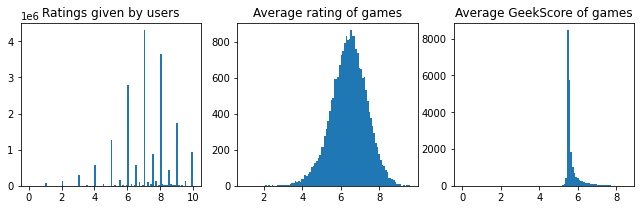

In [743]:
# hide
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(11,3))
ax1.hist(db.df("SELECT rating FROM reviews").astype(float), bins=100)
ax1.title.set_text('Ratings given by users')
ax2.hist(df[y], bins=100)
ax2.title.set_text('Average rating of games')
ax3.hist(df['bayesaverage'], bins=100);
ax3.title.set_text('Average GeekScore of games')

Users give ratings that are rounded, a 8 is more likely than a 8.25, that's why you see the spikes. Looking at the games, we see a nice normal distribution with a mean of 6.4 (for the purists: no I've got no intention of testing for normality here😊).

In addition BGG has it's own Geekscore, which penalizes games with few reviews. You see that distribution is much more 'squashed', with an hardly any games above a 6.

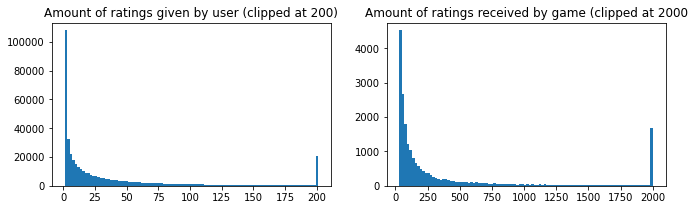

In [765]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(11,3))
users = db.df("SELECT COUNT(*) as count, AVG(rating) as average FROM reviews GROUP BY user").astype(float)
users['count'].clip(0,201, inplace=True)
ax1.hist(users['count'], bins=100)
ax1.title.set_text('Amount of ratings given by user (clipped at 200)')
games = db.df("SELECT COUNT(*) as count, AVG(rating) as average FROM reviews GROUP BY ID").astype(float)
games['count'].clip(0,2001, inplace=True)
ax2.hist(games['count'], bins=100)
ax2.title.set_text('Amount of ratings received by game (clipped at 2000')

In [766]:
# hide
(len(users.loc[users['count']==1]) / len(users),
sum(users.loc[users['count']==1]['count']) / sum(users['count']),
len(users.loc[users['count']>=201]) / len(users),
sum(users.loc[users['count']>=201]['count']) / sum(users['count']))
# len(games.loc[games['count']<100]) / len(users)

(0.19440137979148095,
 0.005377211536709124,
 0.04901215069183365,
 0.27249440917945195)

In [767]:
# hide
(len(games.loc[games['count']<100]) / len(games),
sum(games.loc[games['count']<100]['count']) / sum(games['count']),
len(games.loc[games['count']>=2001]) / len(games),
sum(games.loc[games['count']>=2001]['count']) / sum(games['count']))

(0.44443426896835936,
 0.06340284554325983,
 0.07628554420989972,
 0.39038374679239046)

For the pareto fans amount you:
* 19% of **users** only leave 1 review. However, these reviews only account for 0.5% of all reviews
* 5% of users (20k) leave more than 200 reviews. Together they account for 27% of reviews
* 44% of **games** reveive less than 100 reviews. However, these reviews only account of 6% of all reviews.
* 7% of games have 2000 or more reviews, However they make up 39% of all reviews

### Rating development over the years

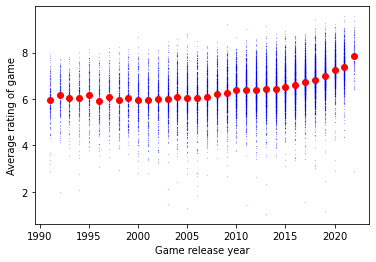

In [754]:
# hide_input
years = df.loc[(df['yearpublished'] > 1990) & (df['yearpublished'] < 2023)]
ax1 = plt.axes()
ax1.scatter(years['yearpublished'], years[y],  color='blue',s=0.01)
ax1.set_xlabel('Game release year')
ax1.set_ylabel('Average rating of game')

years = years.groupby('yearpublished').agg('mean').reset_index()
ax1.scatter(years['yearpublished'], years['average'], color='red');

There seems to be an increase in the ratings over the years. Now are games just better of is there a tendency to rate new games higher? I've composed this dataset already twice in previous years, this now finally pays off:

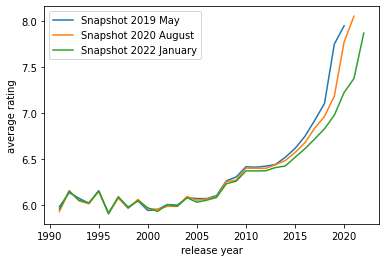

In [748]:
# hide_input
cut = 1990
versions = [('archive/games_detailed_info_2019.csv', 'Snapshot 2019 May'),
            ('archive/games_detailed_info_2020.csv', 'Snapshot 2020 August'),
            ('games_detailed_info.csv', 'Snapshot 2022 January')]
for path, label in versions:
    dfold = pd.read_csv(path)
    df2 = dfold.loc[(dfold['yearpublished'] > cut) & (dfold['yearpublished'] < 2023)]
    yearsold = df2.groupby('yearpublished').agg('mean').reset_index()
    plt.plot(yearsold['yearpublished'], yearsold['average'], label=label)
plt.ylabel('average rating')
plt.xlabel('release year')

plt.legend();

It's a mix of improved quality and hype:
* Scores have been climbing since 2005. There is a rough consensus that boardgames have improved in quality.
* As you see the 3 snapshots diverge around 2015. This is a 'hype' effect, where the early adopters score a new/upcoming games higher. For any year, the blue line (the ratings from the dataset in 2019) scores highest, after the orange (2020) and lowest in the most recent version of the dataset (2022). Games from 2020 where rated with 7.8 in 2020, but two years later that has dropped to 7.2 and now games from 2022 are rated with 7.8! When games are about 5 years old the 'hype' effect is more or less gone and games reach a stable score (around 2014 there is no difference anymore). 

### Relation between complexity of games and ratings

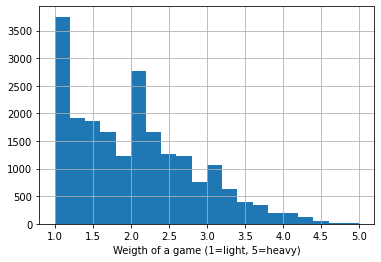

In [750]:
df2 = df.loc[df['averageweight'] > 0]
ax = df2['averageweight'].hist(bins=20)
ax.set_xlabel('Weigth of a game (1=light, 5=heavy)');

BGG has a weight metric, which I understand as the complexity of a game. To get a feel what a number means, here some examples:
* Monopoly: 1.3
* Catan: 2.3
* Chess: 3.7

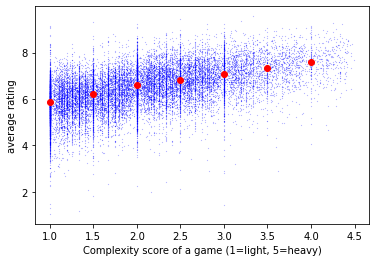

In [756]:
# hide
s = 0.01
ax1 = plt.axes()
ax1.scatter(df2['averageweight'], df2[y],  color='blue',s=s)

df2['complexity'] = (df2['averageweight'] // 0.5 * 0.5).copy()
df2 = df2.loc[df2['complexity']<4.5]
complexity = df2.groupby('complexity').agg('mean').reset_index()
ax1.scatter(complexity['complexity'], complexity['average'], color='red')
ax1.set_xlabel('Complexity score of a game (1=light, 5=heavy)');
ax1.set_ylabel('average rating');

There is a relation between the weight/complexity of the game and the score. More complex games get higher scores, it's almost a 1 point difference between a game with weight 1 and 5!

### 'Experienced' users giving lower scores

In [816]:
new = users.loc[users['count']<30]
middle = users.loc[(users['count']>=30) & (users['count']<=200)]
experienced = users.loc[users['count']>200]
assert len(new) + len(middle) + len(experienced) == len(users)

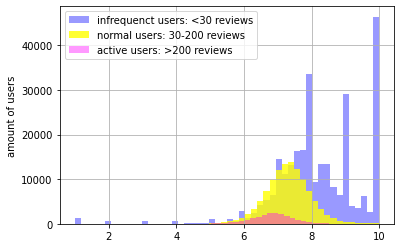

In [827]:
new['average'].hist(bins=50, fc=(0, 0, 1, 0.4), label='infrequenct users: <30 reviews')
middle['average'].hist(bins=50, fc=(1, 1, 0, 0.8), label='normal users: 30-200 reviews')
experienced['average'].hist(bins=50, fc=(1, 0, 1, 0.4), label='active users: >200 reviews')
plt.ylabel('amount of users')
plt.legend();

Here you see the average rating that different user groups are giving. The most active group gives lower scores (6.8 avg) compared to the normal users (7.3 avg) and the infrequent users (8.2 avg). 
Also, while the active users only make up 5% of the population (note the small area), they do give out 27% of the reviews!

Finally, it's notable that 11% of the infrequent users give a 10 on average, which accounts for 0.5% of all reviews. You can make a case for filtering these reviews out.

### Predicting the average rating of a game

In [879]:
df = pd.read_csv('games_detailed_info.csv')

# clip some values to make plotting easier
df['minplaytime'] = df['minplaytime'].clip(0,500)
df['maxplaytime'] = df['minplaytime'].clip(0,500)
df['maxplayers'] = df['minplaytime'].clip(0,20)
df['yearpublished'] = df['yearpublished'].clip(lower=1970, upper=2030, axis=0)
# I'm filtering out the hype years here
df = df.loc[df['yearpublished'] < 2018].reset_index()

usersrated = df['usersrated'].copy()
names = df['primary'].copy()

In [880]:
users.head()

,count,average
0,2.0,9.000000
1,9.0,7.333333
2,14.0,7.521429
3,5.0,7.400000
4,1.0,9.000000


In [881]:
reviews = pd.read_csv('bgg-19m-reviews.csv',index_col=0)

user_review_count = reviews.groupby('user')[['rating']].agg(reviewcount=('rating', 'count')).reset_index()
merged_reviews = reviews.merge(user_review_count,how='left',on='user',suffixes=('','user'),indicator=True)
merged_reviews['only_one_review'] = (merged_reviews['reviewcount'] == 1)*1

In [882]:
merged_reviews.head()

,user,rating,comment,ID,name,reviewcount,_merge,only_one_review
0,Torsten,10.0,NaN,30549,Pandemic,1460.0,both,0
1,mitnachtKAUBO-I,10.0,Hands down my favorite new game of BGG CON 200...,30549,Pandemic,397.0,both,0
2,avlawn,10.0,I tend to either love or easily tire of co-op ...,30549,Pandemic,1038.0,both,0
3,Mike Mayer,10.0,NaN,30549,Pandemic,729.0,both,0
4,Mease19,10.0,This is an amazing co-op game. I play mostly ...,30549,Pandemic,422.0,both,0


In [883]:
newscores = merged_reviews.loc[merged_reviews['only_one_review'] == 0].groupby('name')[['only_one_review', 'rating', 'reviewcount']].agg(score=('rating','mean'))



In [873]:
# newscores.columns = newscores.columns.get_level_values(0)
# newscores.reset_index(inplace=True)
newscores.loc[newscores['name']=='Kingdom Death: Monster']

,index,name,score
9734,9734,Kingdom Death: Monster,8.501357


In [884]:
# add average usercount
reviews = pd.read_csv('bgg-19m-reviews.csv',index_col=0)

user_review_count = reviews.groupby('user')[['rating']].agg(reviewcount=('rating', 'count')).reset_index()
merged_reviews = reviews.merge(user_review_count,how='left',on='user',suffixes=('','user'),indicator=True)
merged_reviews['only_one_review'] = (merged_reviews['reviewcount'] == 1)*1
merged_games = merged_reviews.groupby('name')[['rating', 'only_one_review', 'reviewcount']].agg( avg_rating= ('rating', 'mean'),
                                                                                                num_inactive= ('only_one_review','sum'), 
                                                                                                num_reviews=('rating', 'count'), 
                                                                                                median_review_count= ('reviewcount', 'median'))
merged_reviews.columns = merged_reviews.columns.get_level_values(0)
merged_games['proportion_inactive'] = merged_games['num_inactive'] / merged_games['num_reviews']
merged_games.sort_values('proportion_inactive', ascending=False ,inplace=True)

In [885]:
merged_games.sort_values('num_reviews', ascending=False)[:1000].sort_values('proportion_inactive', ascending=False)

,avg_rating,num_inactive,num_reviews,median_review_count,proportion_inactive
name,,,,,
Kingdom Death: Monster,8.604285,709,8081,54.0,0.087737
Chronicles of Crime,7.731396,1415,17176,101.0,0.082382
Gloomhaven,8.741014,1967,47931,56.0,0.041038
Tainted Grail: The Fall of Avalon,8.264142,309,8052,66.0,0.038376
Dark Souls: The Board Game,6.516506,116,3651,60.0,0.031772
...,...,...,...,...,...
San Marco,7.169221,0,4324,329.0,0.000000
Timeline: Discoveries,6.726627,0,3641,203.0,0.000000
Last Will,7.185479,0,9426,243.0,0.000000


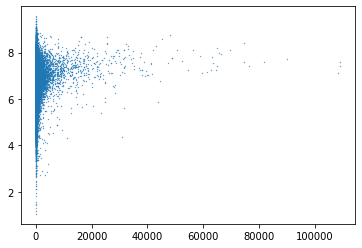

In [886]:
plt.scatter(merged_games['num_reviews'],merged_games['avg_rating'], s=0.1)

In [887]:
df.rename(columns={'primary':'name'}, inplace=True)
df = df.merge(merged_games,how='left',on='name')

There seems to be a kind of relationship between the amount of reviews a user gives and the average score given

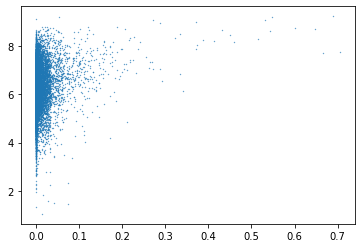

In [888]:

plt.scatter(df['proportion_inactive'], df['average'], s=0.1)


Games that have a high proportion of users that only rated one game (the game in question) have a higher score.

In [889]:
# drop irrelevant variables

relevant = ['name', 'average', 'yearpublished', 'minplayers', 'maxplayers',
        'minplaytime',
       'maxplaytime', 'minage', 'boardgamecategory', 'boardgamemechanic', 'boardgamefamily',
       'averageweight', 'median_review_count', 'proportion_inactive'
#        ,'usersrated', 'numcomments', 'numweights','avg_user_rating'
       ]

minimal = ['average', 'averageweight', 'median_review_count', 'proportion_inactive']
#        ,'usersrated', 'numcomments', 'numweights','avg_user_rating'
       
# maybe for later, now exclude:
# 'playtime' too much overlap with minplaytime and maxplaytime
# 'suggested_num_players', 'suggested_playerage','suggested_language_dependence',
# 'bayesaverage' of course correlates too much, stddev as well
# 'wanting', 'wishing','trading','owned' also has correlation
df = df[minimal]
# df.drop('boardgamefamily', axis=1, inplace=True)

num_x, cat_x = types(df, 'average')

In [890]:
chars = "[]'\""
# df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_,]+', '', x))

onehot = ['boardgamecategory', 'boardgamemechanic','boardgamefamily']
onehot = ['boardgamecategory', 'boardgamemechanic']
for cat in onehot:
    # df[cat] = df[cat].str.replace('[/]+', ",", regex=True)
    df[cat] = df[cat].str.replace('[^A-Za-z0-9_,]+', "", regex=True)
    df[cat] = df[cat].str.replace('[^A-Za-z0-9_,]+', "", regex=True)
    onehotencoded = df[cat].str.get_dummies(sep=',',)
    onehotencoded.fillna(0, inplace=True)
    print(cat, len(onehotencoded.columns))
    df = pd.concat([df.drop(cat, axis=1), onehotencoded], axis=1)
    # some columns like Deduction are duplicated, since they appear in both category and mechanic
    df = df.loc[:,~df.columns.duplicated()]
    
        
  



KeyError: 'boardgamecategory'

### Training

In [891]:

train, test = train_test_split(df, test_size=0.2)
x, y = split(train, 'average')
x_test, y_test = split(test, 'average')
len(df), len(train), len(test)


(17362, 13889, 3473)

In [892]:
params = {'num_leaves':10, 'min_data_in_leaf':100, 'max_depth':5}
model = lgb.LGBMRegressor(objective='regression',random_state=112, **params) #
model = model.fit(x,y)


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


In [893]:
model.score(x,y)

0.3871535801890781

In [894]:
model.score(x_test,y_test)

0.35057556701036374

In [895]:
import pickle
save(model, 'models/lightgbm.pickle')

data = {'train_x':x, 'train_y':y, 'test_x':x_test, 'test_y':y_test, 'names':names, 'full_df':df}
save(data, 'models/data.pickle')

In [896]:
x_full,_ = split(df, 'average')
# preds = model.predict(x_full)
preds = model.predict(x_full)
df2 = df.copy()
df2['preds'] = preds
df2['residual'] = df2['average'] - df2['preds']
df2['name'] = names
df2['usersrated'] = usersrated
df2.sort_values('residual', inplace=True, ascending=False)
df2.reset_index(inplace=True)

In [898]:
df2.loc[(df2['name'] == 'Breaking Away')]

,index,average,averageweight,median_review_count,proportion_inactive,preds,residual,name,usersrated
566,4068,7.31737,2.2759,506.0,0.0,6.182351,1.135019,Breaking Away,446


In [899]:
# df2 = df.loc[df['average'] > 8]
df2.loc[(df2['usersrated'] > 1000) & (df2['averageweight'] > 1.5)][['name', 'average', 'preds', 'residual', 'usersrated', 'averageweight']][:200]

,name,average,preds,residual,usersrated,averageweight
58,Azul,7.79966,6.064053,1.735607,62860,1.7639
129,The Resistance: Avalon,7.56401,6.064053,1.499957,28818,1.7638
148,Patchwork,7.63916,6.177223,1.461937,52225,1.6239
179,Secret Hitler,7.54907,6.131411,1.417659,20834,1.6784
202,7 Wonders Duel,8.10830,6.715234,1.393066,69528,2.2234
210,Flamme Rouge,7.53518,6.155519,1.379661,13881,1.6939
273,Pandemic Legacy: Season 1,8.59350,7.283149,1.310351,45064,2.8310
297,Splendor,7.44000,6.153927,1.286073,64734,1.7939
307,Ticket to Ride: Germany,7.62215,6.340537,1.281613,1256,1.7812
352,Glüx,7.10678,5.856423,1.250357,1317,1.6000


In [ ]:

len(names), len(df)

(16037, 16037)

## Exploration: Quantitative Variables

In [ ]:
path_train = 'games_detailed_info.csv'
num_x = eda.num_x
import altair as alt
from altair.expr import datum
def gen_chart(name):
    return alt.Chart(path_train).mark_point(
        color='red',
        opacity=0.1,
        size=1
    ).encode(
        x= alt.X(name+':Q',scale=alt.Scale(zero=False)) ,
        y='average:Q'
    ).properties(
        width=150,
        height=150
    )

#create a list of subplots
subplts = []
for name in num_x:
    subplts.append(gen_chart(name))
plots_per_row = 7
hconcat = [alt.hconcat(*subplts[i:i+plots_per_row]) for i in range(0, len(subplts), plots_per_row)]
alt.vconcat(*hconcat)

alt.VConcatChart(...)

## Exploration: Quantitative Variables interactive chart

In [ ]:
import altair as alt
brush = alt.selection(type='interval', resolve='global')

base = alt.Chart(path_train).mark_point(        opacity=0.1,
        size=2).encode(
    y='average:Q',
    color=alt.condition(brush, alt.ColorValue('red'), alt.ColorValue('gray')),
).add_selection(
    brush
).properties(
    width=140,
    height=140
)
num_x.append('average')
subplts = []
for name in num_x:
    subplts.append(base.encode(alt.X(name+':Q',scale=alt.Scale(zero=False))))
plots_per_row = 7
hconcat = [alt.hconcat(*subplts[i:i+plots_per_row]) for i in range(0, len(subplts), plots_per_row)]
alt.vconcat(*hconcat)

alt.VConcatChart(...)

In [ ]:
## Exploration: Categorical Variables

In [ ]:
cat_x = eda.cat_x
def gen_chart(name):
  chart = alt.Chart(path_train).mark_bar().encode(
        x= alt.X(name+':N', bin=False),
        y='count()',
        color=alt.condition(brush, alt.ColorValue('red'), alt.ColorValue('gray'))
    ).properties(
        width=140,
        height=30
    ).add_selection(
    brush)

  price = alt.Chart(path_train).mark_boxplot().encode(
        x= alt.X(name+':N'),
        y='SalePrice:Q',
        color=alt.condition(brush, alt.ColorValue('red'), alt.ColorValue('gray'))
    ).properties(
        width=140,
        height=140
    ).add_selection(
    brush)
  return price & chart

brush = alt.selection(type='interval', resolve='global')
#create a list of subplots
subplts = []
for name in cat_x:
    subplts.append(gen_chart(name))
plots_per_row = 7
hconcat = [alt.hconcat(*subplts[i:i+plots_per_row]) for i in range(0, len(subplts), plots_per_row)]
alt.vconcat(*hconcat)

alt.VConcatChart(...)

In [ ]:
train_x['YearBuilt'].describe()

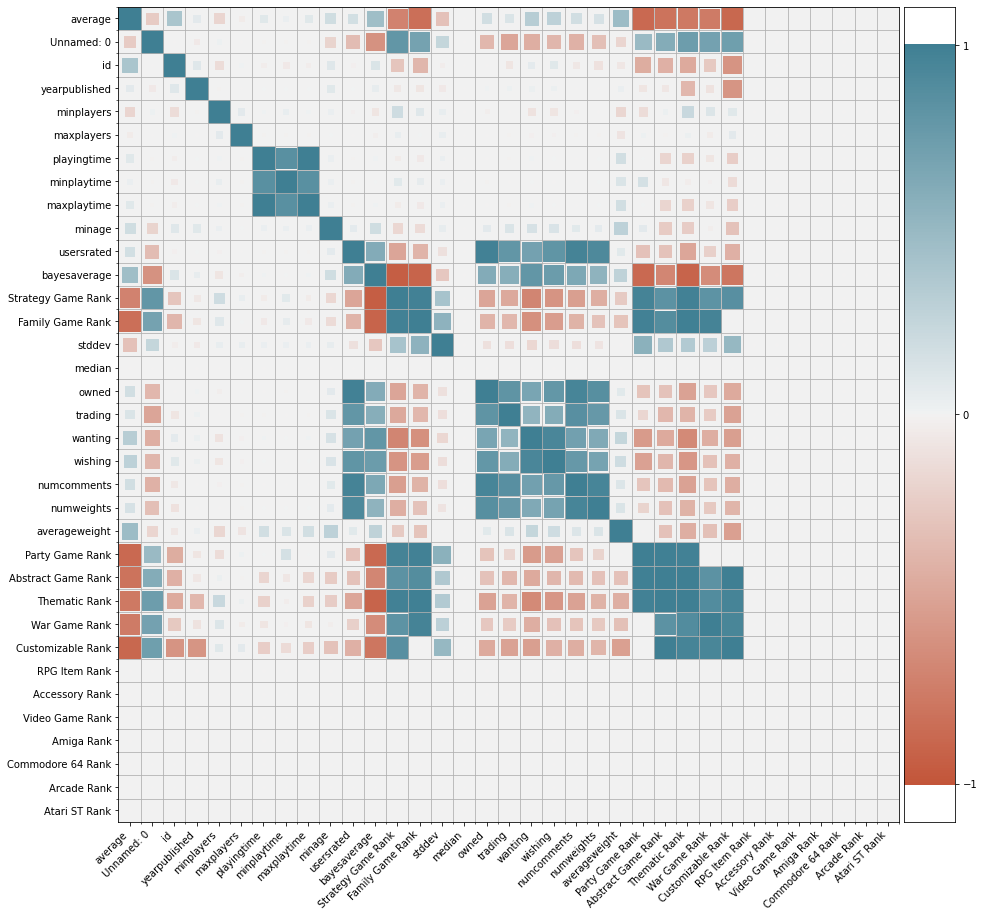

In [ ]:
# pip install heatmapz
import heatmap
from heatmap import heatmap, corrplot
from matplotlib import pyplot as plt

plt.figure(figsize=(15, 15))
corrplot(pd.concat([eda.data_y,eda.data_x],axis=1).corr())

In [ ]:
# check how nan values are correlated
from aocutils.datascience import nan_inspect
import altair as alt
df = nan_inspect(df).reset_index()
df = df.melt('index', var_name='to', value_name='corr')
plt.figure(figsize=(15, 15))
alt.Chart(df).mark_rect().encode(
    x=alt.X('index:O',sort=alt.EncodingSortField(field="corr", op="sum", order='descending')),
    y=alt.Y('to:O',sort=alt.EncodingSortField(field="corr", op="sum", order='descending')),
    color='corr:Q'
)

15     376
14      73
16    1082
13       6
17    2366
18    4023
19    5236
20    4670
21    2591
22     945
23     231
24      31
26       1
dtype: int64


alt.Chart(...)

<Figure size 1080x1080 with 0 Axes>